# Programming Assignment 2 - Policy Gradient Methods

## Imports

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.special import softmax
from collections import deque, namedtuple
from torch.distributions import Categorical

## Cart Pole

### Environment Setup

In [2]:
game = 'CartPole-v1'

env = gym.make(game)
THRESHOLD = 475.0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

In [3]:
# Reward vs episodes curve with std bands
def return_vs_episodes(allrewards, labels, title):
    allrewards = np.array(allrewards)

    chunksize = len(allrewards[0][0]) // 100
    chunk_rewards = np.empty((allrewards.shape[0], allrewards.shape[1], int(np.ceil(allrewards.shape[2] / chunksize))))

    for i in range(chunk_rewards.shape[-1]-1):
        chunk_rewards[:, :, i] = allrewards[:, :, chunksize*i: chunksize*(i+1)-1].mean(axis=-1)
    chunk_rewards[:, :, chunk_rewards.shape[-1]-1] = allrewards[:, :, chunksize*(chunk_rewards.shape[-1]-1): ].mean(axis=-1)

    meanrewards, stdrewards = [], []
    for reward in chunk_rewards:
        meanrewards.append(np.mean(reward, axis=0))
        stdrewards.append(np.std(reward, axis=0))
    
    plt.figure(figsize=(12, 8))
    for mean, std, label in zip(meanrewards, stdrewards, labels):
        plt.plot(mean, label=label)
        plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.5)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Return', fontsize=12)
    plt.xticks(range(0,chunk_rewards.shape[-1]+1, int(np.floor(chunk_rewards.shape[-1] / 5))), 
               labels=range(0, allrewards.shape[-1]+1, int(np.floor(allrewards.shape[-1] / 5))))
    plt.title(title, fontsize=18)
    plt.legend()
    plt.savefig(title+'.png', dpi=450)
    plt.show()

### Dueling DQN

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor

#### Dueling DQN Agent Definition

In [5]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed=0, adv_type='avg', fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.adv = nn.Linear(fc2_units, action_size)
        self.value = nn.Linear(fc2_units, 1)
        self.adv_type = adv_type

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x_adv = self.adv(x)
        x_value = self.value(x)
        if self.adv_type == 'avg':
            advAverage = torch.mean(x_adv, dim=1, keepdim=True)
            q =  x_value + x_adv - advAverage
        else:
            advMax, _ = torch.max(x_adv, dim=1, keepdim=True)
            q =  x_value + x_adv - advMax
        return q

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
class DuelDQNAgent():

    def __init__(self, state_size, action_size, seed=0, adv_type='avg', polyak_factor=0.01, lr=5e-4):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.polyak_factor = polyak_factor
        np.random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork(state_size, action_size, seed, adv_type).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, adv_type).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.qnetwork_target.eval()
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        for target_param, param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.polyak_factor*param.data + (1-self.polyak_factor)*target_param.data)

    def act(self, state, eps=0.05, tau=1.0, type='epsilon-greedy'):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if type == 'epsilon-greedy':
            if random.random() > eps:
                return np.argmax(action_values.cpu().data.numpy())
            else:
                return random.choice(np.arange(self.action_size))
        else:
            x = [action_value/tau for action_value in action_values.cpu().data.numpy()][0]
            return np.random.choice(np.arange(self.action_size), p=softmax(x))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradient Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            #print("param.grad. ===>",param.grad)
            if param.grad != None:
              param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

#### DQN Algorithm

In [8]:
def dqn(agent, n_episodes=10000, max_t=1000, type='epsilon-greedy', start=1.0, end=0.01, decay=0.995, THRESHOLD=THRESHOLD):
    rewards = np.empty(n_episodes)
    scores_window = deque(maxlen=20)

    param = start

    for i_episode in range(n_episodes):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, param, type)
            next_state, reward, done, _, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        rewards[i_episode] = score
        param = max(end, decay*param)

        avgscore = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode+1, avgscore), end="")

        if i_episode % 100 == 99:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode+1, avgscore))
        
        if avgscore >= THRESHOLD:
            print('\rProblem solved by crossing threshold at episode {}'.format(i_episode+1))
            rewards[i_episode+1:] = THRESHOLD
            break

    return rewards

#### Hyperparameter Selection

In [9]:
eps_start = 1.0
eps_end = 0.01
tau_start = 10.0
tau_end = 0.1
polyak = 0.01
decays = [0.995, 0.99, 0.95]
learning_rates = [5e-5, 1e-4, 5e-4]

seed = 42
episodes = 1000

max_t = 1000
DuelDQNRewards = {}

for lr in learning_rates:
    for decay in decays:
        env.reset(seed=seed)
        agent = DuelDQNAgent(state_size=state_shape, 
                                action_size=action_shape, 
                                seed=seed, 
                                adv_type="max", 
                                polyak_factor=polyak, 
                                lr=lr)
        DuelDQNRewards[('epsilon-greedy', eps_start, eps_end, lr, decay)] = np.mean(dqn(agent, 
                                                                                        n_episodes=episodes, 
                                                                                        max_t=max_t,
                                                                                        type='epsilon-greedy', 
                                                                                        start=eps_start, 
                                                                                        end=eps_end, 
                                                                                        decay=decay))
        
        env.reset(seed=seed)
        agent = DuelDQNAgent(state_size=state_shape, 
                                action_size=action_shape, 
                                seed=seed, 
                                adv_type="max", 
                                polyak_factor=polyak,
                                lr=lr)
        DuelDQNRewards[('softmax', tau_start, tau_end, lr, decay)] = np.mean(dqn(agent, 
                                                                                        n_episodes=episodes, 
                                                                                        max_t=max_t,
                                                                                        type='softmax', 
                                                                                        start=tau_start, 
                                                                                        end=tau_end, 
                                                                                        decay=decay))

best_conf = max(DuelDQNRewards, key=lambda x: DuelDQNRewards[x])
print(best_conf)

Episode 100	Average Score: 12.70
Episode 200	Average Score: 21.55
Episode 300	Average Score: 195.30
Episode 400	Average Score: 321.10
Episode 500	Average Score: 370.60
Episode 600	Average Score: 159.35
Episode 700	Average Score: 100.55
Episode 800	Average Score: 17.550
Episode 900	Average Score: 16.45
Episode 1000	Average Score: 19.85
Episode 100	Average Score: 21.35
Episode 200	Average Score: 20.15
Episode 300	Average Score: 22.50
Episode 400	Average Score: 24.70
Episode 500	Average Score: 33.00
Episode 600	Average Score: 113.80
Episode 700	Average Score: 223.50
Episode 800	Average Score: 227.60
Episode 900	Average Score: 248.80
Episode 1000	Average Score: 379.80
Episode 100	Average Score: 11.60
Episode 200	Average Score: 109.40
Episode 300	Average Score: 198.75
Episode 400	Average Score: 296.25
Problem solved by crossing threshold at episode 453
Episode 100	Average Score: 21.35
Episode 200	Average Score: 20.15
Episode 300	Average Score: 67.35
Episode 400	Average Score: 311.80
Episode

#### Type-1 Dueling DQN

In [10]:
episodes = 1000
polyak = 0.01

avg_adv_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = DuelDQNAgent(state_size=state_shape, 
                         action_size=action_shape, 
                         seed=seed, 
                         adv_type="avg", 
                         polyak_factor=polyak,
                         lr=best_conf[3])
    avg_adv_rewards.append(dqn(agent, 
                               n_episodes=episodes,
                               max_t=max_t,
                               type=best_conf[0],
                               start=best_conf[1],
                               end=best_conf[2],
                               decay=best_conf[4]))

Episode 100	Average Score: 192.25
Problem solved by crossing threshold at episode 153
Episode 100	Average Score: 223.25
Problem solved by crossing threshold at episode 170
Episode 100	Average Score: 217.70
Problem solved by crossing threshold at episode 179
Episode 100	Average Score: 229.05
Episode 200	Average Score: 231.45
Problem solved by crossing threshold at episode 252
Episode 100	Average Score: 268.70
Episode 200	Average Score: 298.90
Problem solved by crossing threshold at episode 255


#### Type-2 Dueling DQN

In [11]:
episodes = 1000
polyak = 0.01

max_adv_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = DuelDQNAgent(state_size=state_shape, 
                         action_size=action_shape, 
                         seed=seed, 
                         adv_type="max", 
                         polyak_factor=polyak,
                         lr=best_conf[3])
    max_adv_rewards.append(dqn(agent, 
                               n_episodes=episodes,
                               max_t=max_t,
                               type=best_conf[0],
                               start=best_conf[1],
                               end=best_conf[2],
                               decay=best_conf[4]))

Episode 100	Average Score: 253.85
Problem solved by crossing threshold at episode 157
Episode 100	Average Score: 303.15
Problem solved by crossing threshold at episode 187
Episode 100	Average Score: 178.60
Episode 200	Average Score: 122.85
Episode 300	Average Score: 155.25
Problem solved by crossing threshold at episode 387
Episode 100	Average Score: 297.15
Episode 200	Average Score: 326.55
Problem solved by crossing threshold at episode 258
Episode 100	Average Score: 229.55
Problem solved by crossing threshold at episode 163


#### Return Vs Episodes plot

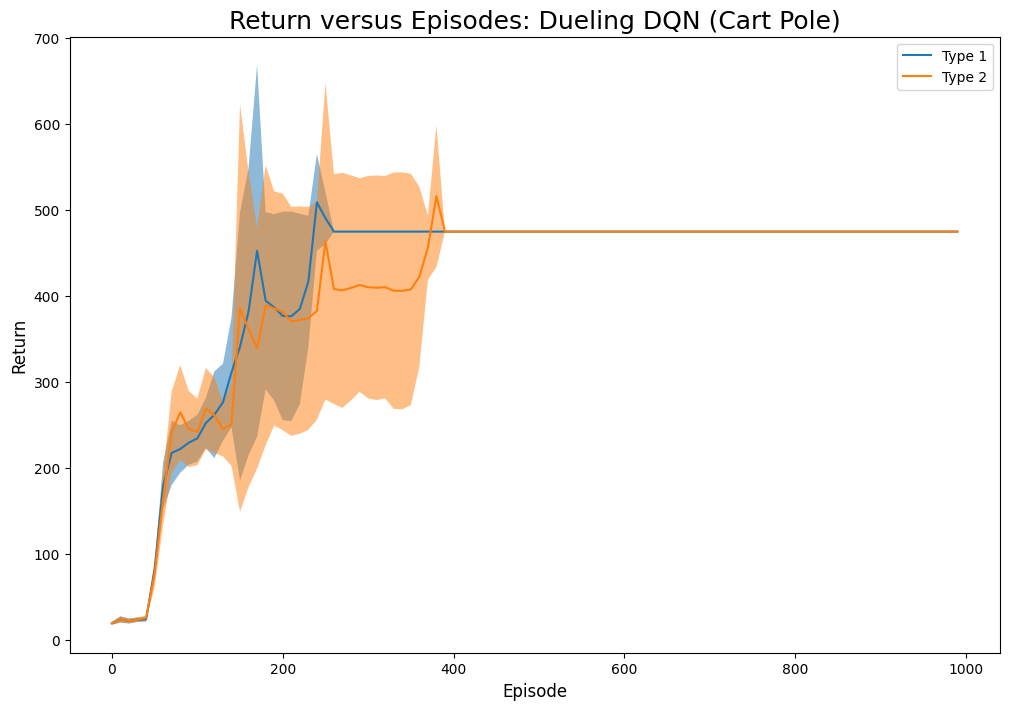

In [12]:
return_vs_episodes([avg_adv_rewards, max_adv_rewards], ['Type 1', 'Type 2'], 'Return versus Episodes: Dueling DQN (Cart Pole)')

### Monte-Carlo REINFORCE

In [13]:
GAMMA = 0.99            # discount factor

#### MC REINFORCE Agent Definition

In [14]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

class PolicyNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed=0, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.affine1 = nn.Linear(state_size, fc1_units)
        self.affine2 = nn.Linear(fc1_units, fc2_units)
        self.action = nn.Linear(fc2_units, action_size)


    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.affine1(state))
        x = F.relu(self.affine2(x))
        return F.softmax(self.action(x), dim=-1)
    

class ValueNetwork(nn.Module):

    def __init__(self, state_size, seed=0, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(ValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.affine1 = nn.Linear(state_size, fc1_units)
        self.affine2 = nn.Linear(fc1_units, fc2_units)
        self.value = nn.Linear(fc2_units, 1)

    def forward(self, state):
        x = F.relu(self.affine1(state))
        x = F.relu(self.affine2(x))
        return self.value(x) 

In [15]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

class MC_Agent():

    def __init__(self, state_size, action_size, seed=0, baseline=False, lr=5e-4):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        np.random.seed(seed)
        self.eps = np.finfo(np.float32).eps.item()
        self.baseline = baseline

        ''' Predictive Networks '''
        self.actor = PolicyNetwork(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        if baseline:
            self.critic = ValueNetwork(state_size, seed).to(device)
            self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def step(self, state, action, reward, next_state, done):
        self.rewards.append(reward)
        if self.baseline:
            self.learn_baseline(GAMMA, state, reward, next_state)
        if done:
            self.learn(GAMMA)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.actor(state)
        if self.baseline:
            state_value = self.critic(state)
        else:
            state_value = None
        m = Categorical(probs)
        action = m.sample()
        self.saved_actions.append(SavedAction(m.log_prob(action), state_value))
        return action.item()

    def learn(self, gamma):
        G = 0.0
        returns = []
        policy_losses = []
        for r in self.rewards[::-1]:
            # calculate the discounted value
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps)

        for (log_prob, value), G in zip(self.saved_actions, returns):
            if self.baseline:
                advantage = G - value.item()
                policy_losses.append(-log_prob * advantage)
            else:
                policy_losses.append(-log_prob * G)


        ''' Compute loss '''
        actor_loss = torch.stack(policy_losses).sum()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()

        for param in self.actor.parameters():
            if param.grad != None:
                param.grad.data.clamp_(-1, 1)

        self.actor_optimizer.step()
        # reset rewards and action buffer
        del self.rewards[:]
        del self.saved_actions[:]

    def learn_baseline(self, gamma, state, reward, next_state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
        value = self.critic(state)
        reward = (reward - np.array(self.rewards).mean()) / (np.array(self.rewards).std() + self.eps)
        TD_target = reward + gamma*self.critic(next_state)
        criterion = nn.L1Loss()
        critic_loss = criterion(value, TD_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()

        for param in self.critic.parameters():
            if param.grad != None:
                param.grad.data.clamp_(-1, 1)

        self.critic_optimizer.step()

#### MC REINFORCE Algorithm

In [16]:
def mc_reinforce(agent, n_episodes=10000, max_t=1000):
    rewards = np.empty(n_episodes)

    scores_window = deque(maxlen=20)

    for i_episode in range(n_episodes):
        state, _ = env.reset()
        
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        rewards[i_episode] = score

        avgscore = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode+1, avgscore), end="")

        if i_episode % 100 == 99:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode+1, avgscore))
        
        if avgscore >= THRESHOLD:
            print('\rProblem solved by crossing threshold at episode {}'.format(i_episode+1))
            rewards[i_episode+1:] = THRESHOLD
            break

    return rewards

#### Hyperparameter Selection

In [17]:
learning_rates = [1e-4, 5e-4, 1e-3]

seed = 48
episodes = 1000

MCREINFORCERewards = {}
max_t = 1000 

for lr in learning_rates:
    env.reset(seed=seed)
    agent = MC_Agent(state_size=state_shape, 
                     action_size=action_shape, 
                     seed=seed, 
                     baseline=True,
                     lr=lr)
    MCREINFORCERewards[lr] = np.mean(mc_reinforce(agent, n_episodes=episodes, max_t=max_t))

best_lr = max(MCREINFORCERewards, key=lambda x: MCREINFORCERewards[x])
print(best_lr)

Episode 100	Average Score: 23.25
Episode 200	Average Score: 30.60
Episode 300	Average Score: 31.60
Episode 400	Average Score: 31.40
Episode 500	Average Score: 33.60
Episode 600	Average Score: 31.55
Episode 700	Average Score: 52.25
Episode 800	Average Score: 72.60
Episode 900	Average Score: 69.40
Episode 1000	Average Score: 110.90
Episode 100	Average Score: 25.75
Episode 200	Average Score: 64.00
Episode 300	Average Score: 149.05
Episode 400	Average Score: 217.80
Episode 500	Average Score: 383.75
Problem solved by crossing threshold at episode 530
Episode 100	Average Score: 52.80
Episode 200	Average Score: 89.005
Episode 300	Average Score: 382.05
Problem solved by crossing threshold at episode 385
0.001


#### Without Baseline

In [18]:
episodes = 1000

no_baseline_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = MC_Agent(state_size=state_shape, 
                     action_size=action_shape, 
                     seed=seed, 
                     baseline=False,
                     lr=best_lr)
    no_baseline_rewards.append(mc_reinforce(agent, n_episodes=episodes, max_t=max_t))

Episode 100	Average Score: 51.95
Episode 200	Average Score: 244.05
Problem solved by crossing threshold at episode 249
Episode 100	Average Score: 29.15
Episode 200	Average Score: 109.45
Episode 300	Average Score: 133.40
Problem solved by crossing threshold at episode 398
Episode 100	Average Score: 36.50
Episode 200	Average Score: 204.35
Problem solved by crossing threshold at episode 217
Episode 100	Average Score: 39.50
Episode 200	Average Score: 174.50
Problem solved by crossing threshold at episode 293
Episode 100	Average Score: 68.30
Episode 200	Average Score: 147.90
Episode 300	Average Score: 124.90
Problem solved by crossing threshold at episode 338


#### With Baseline

In [19]:
episodes = 1000

with_baseline_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = MC_Agent(state_size=state_shape, 
                     action_size=action_shape, 
                     seed=seed, 
                     baseline=True,
                     lr=best_lr)
    with_baseline_rewards.append(mc_reinforce(agent, n_episodes=episodes, max_t=max_t))

Episode 100	Average Score: 84.90
Episode 200	Average Score: 90.800
Problem solved by crossing threshold at episode 287
Episode 100	Average Score: 92.70
Episode 200	Average Score: 205.20
Problem solved by crossing threshold at episode 290
Episode 100	Average Score: 33.10
Episode 200	Average Score: 172.15
Episode 300	Average Score: 223.70
Problem solved by crossing threshold at episode 337
Episode 100	Average Score: 120.15
Episode 200	Average Score: 265.80
Episode 300	Average Score: 188.20
Episode 400	Average Score: 252.10
Episode 500	Average Score: 173.20
Episode 600	Average Score: 401.60
Problem solved by crossing threshold at episode 605
Episode 100	Average Score: 65.55
Episode 200	Average Score: 162.10
Problem solved by crossing threshold at episode 261


#### Return Vs Episodes plot

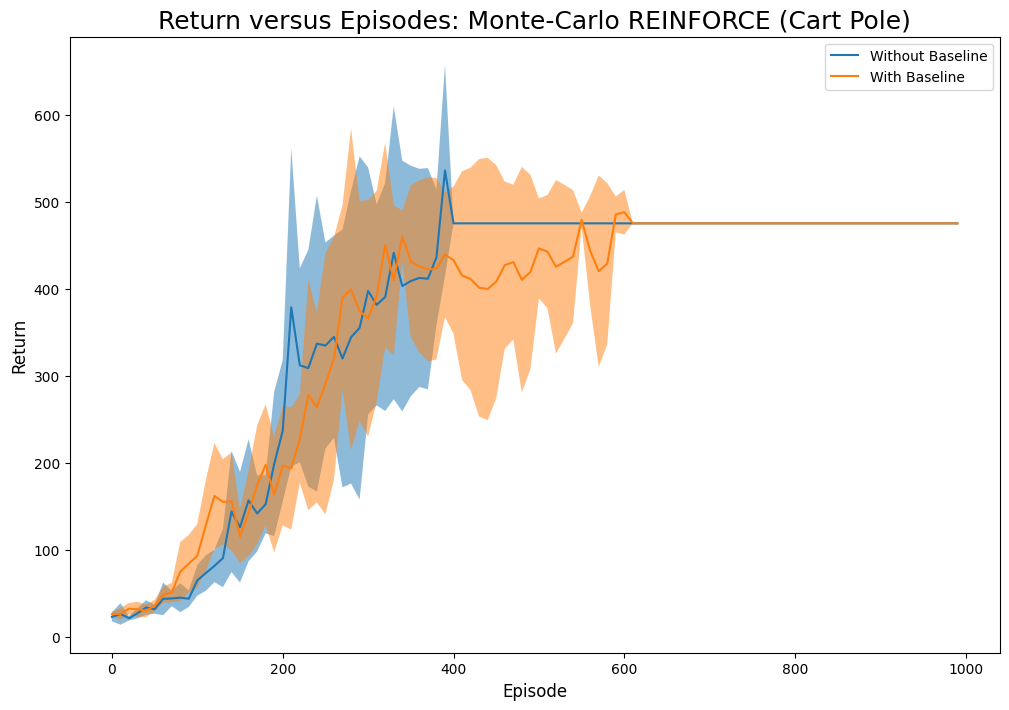

In [20]:
return_vs_episodes([no_baseline_rewards, with_baseline_rewards], ['Without Baseline', 'With Baseline'], 'Return versus Episodes: Monte-Carlo REINFORCE (Cart Pole)')

## Acrobot

In [21]:
game = 'Acrobot-v1'

env = gym.make(game)
THRESHOLD = -100.0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

### Dueling DQN

#### Hyperparameter Selection

In [22]:
eps_start = 1.0
eps_end = 0.01
tau_start = 10.0
tau_end = 0.1
polyak = 0.01
decays = [0.995, 0.99, 0.95]
learning_rates = [5e-5, 1e-4, 5e-4]

seed = 42
episodes = 1000

max_t = 3000
DuelDQNRewards = {}

for lr in learning_rates:
    for decay in decays:
        env.reset(seed=seed)
        agent = DuelDQNAgent(state_size=state_shape, 
                                action_size=action_shape, 
                                seed=seed, 
                                adv_type="max", 
                                polyak_factor=polyak, 
                                lr=lr)
        DuelDQNRewards[('epsilon-greedy', eps_start, eps_end, lr, decay)] = np.mean(dqn(agent, 
                                                                                        n_episodes=episodes, 
                                                                                        max_t=max_t,
                                                                                        type='epsilon-greedy', 
                                                                                        start=eps_start, 
                                                                                        end=eps_end, 
                                                                                        decay=decay))
        
        env.reset(seed=seed)
        agent = DuelDQNAgent(state_size=state_shape, 
                                action_size=action_shape, 
                                seed=seed, 
                                adv_type="max", 
                                polyak_factor=polyak,
                                lr=lr)
        DuelDQNRewards[('softmax', tau_start, tau_end, lr, decay)] = np.mean(dqn(agent, 
                                                                                        n_episodes=episodes, 
                                                                                        max_t=max_t,
                                                                                        type='softmax', 
                                                                                        start=tau_start, 
                                                                                        end=tau_end, 
                                                                                        decay=decay,
                                                                                        THRESHOLD=THRESHOLD))

best_conf = max(DuelDQNRewards, key=lambda x: DuelDQNRewards[x])
print(best_conf)

Episode 100	Average Score: -198.00
Episode 200	Average Score: -131.00
Episode 300	Average Score: -111.60
Episode 400	Average Score: -93.305
Episode 500	Average Score: -99.105
Episode 600	Average Score: -89.250
Episode 700	Average Score: -102.00
Episode 800	Average Score: -82.155
Episode 900	Average Score: -94.95
Episode 1000	Average Score: -81.90
Episode 100	Average Score: -1906.00
Episode 200	Average Score: -2090.20
Episode 300	Average Score: -2023.40
Episode 400	Average Score: -1719.35
Episode 500	Average Score: -538.100
Episode 600	Average Score: -178.90
Episode 700	Average Score: -141.15
Episode 800	Average Score: -119.10
Episode 900	Average Score: -129.75
Episode 1000	Average Score: -135.55
Episode 100	Average Score: -247.45
Episode 200	Average Score: -94.900
Episode 300	Average Score: -96.205
Episode 400	Average Score: -102.35
Episode 500	Average Score: -84.200
Episode 600	Average Score: -89.90
Episode 700	Average Score: -82.455
Episode 800	Average Score: -96.50
Episode 900	Avera

#### Type-1 Dueling DQN

In [23]:
episodes = 1000
polyak = 0.01

avg_adv_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = DuelDQNAgent(state_size=state_shape, 
                         action_size=action_shape, 
                         seed=seed, 
                         adv_type="avg", 
                         polyak_factor=polyak,
                         lr=best_conf[3])
    avg_adv_rewards.append(dqn(agent, 
                               n_episodes=episodes,
                               type=best_conf[0],
                               start=best_conf[1],
                               end=best_conf[2],
                               decay=best_conf[4],
                               THRESHOLD=THRESHOLD))

Episode 100	Average Score: -100.50
Problem solved by crossing threshold at episode 115
Problem solved by crossing threshold at episode 95
Problem solved by crossing threshold at episode 42
Problem solved by crossing threshold at episode 54
Problem solved by crossing threshold at episode 52


#### Type-2 Dueling DQN

In [24]:
episodes = 1000

max_adv_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = DuelDQNAgent(state_size=state_shape, 
                         action_size=action_shape, 
                         seed=seed, 
                         adv_type="max", 
                         polyak_factor=polyak,
                         lr=best_conf[3])
    max_adv_rewards.append(dqn(agent, 
                               n_episodes=episodes,
                               type=best_conf[0],
                               start=best_conf[1],
                               end=best_conf[2],
                               decay=best_conf[4],
                               THRESHOLD=THRESHOLD))

Problem solved by crossing threshold at episode 73
Problem solved by crossing threshold at episode 56
Problem solved by crossing threshold at episode 81
Problem solved by crossing threshold at episode 57
Problem solved by crossing threshold at episode 47


#### Return Vs Episodes plot

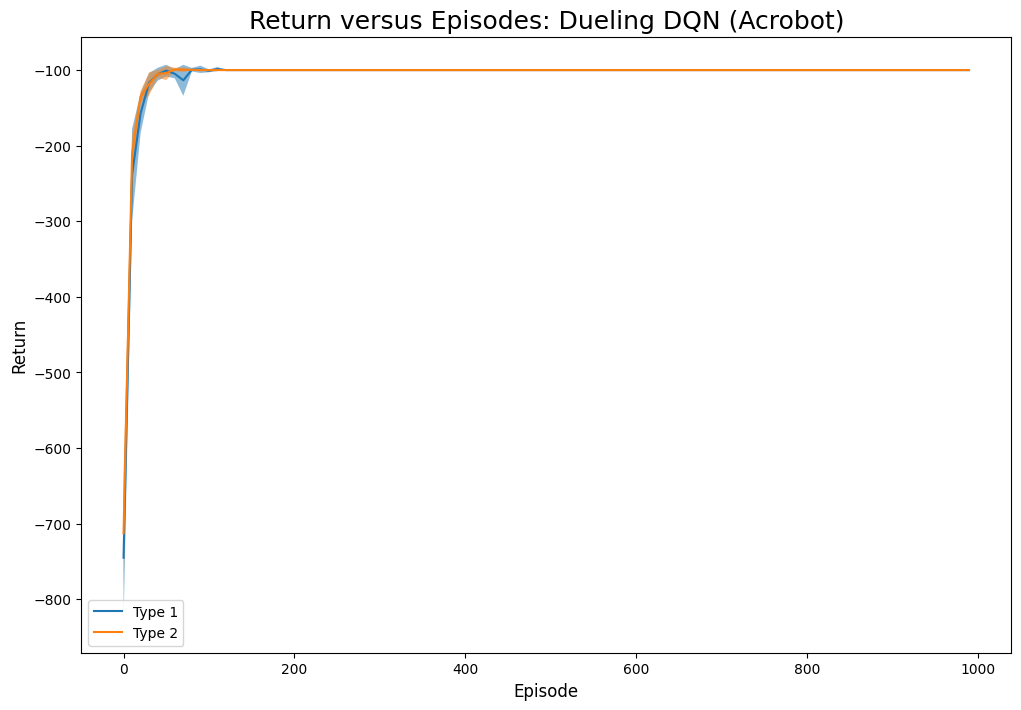

In [25]:
return_vs_episodes([avg_adv_rewards, max_adv_rewards], ['Type 1', 'Type 2'], 'Return versus Episodes: Dueling DQN (Acrobot)')

### Monte-Carlo REINFORCE

#### Hyperparameter Selection

In [26]:
learning_rates = [1e-4, 5e-4, 1e-3]

seed = 42
episodes = 1000

MCREINFORCERewards = {}
max_t = 3000

for lr in learning_rates:
    env.reset(seed=seed)
    agent = MC_Agent(state_size=state_shape, 
                     action_size=action_shape, 
                     seed=seed, 
                     baseline=True,
                     lr=lr)
    MCREINFORCERewards[lr] = np.mean(mc_reinforce(agent, n_episodes=episodes, max_t=max_t))

best_lr = max(MCREINFORCERewards, key=lambda x: MCREINFORCERewards[x])
print(best_lr)

Episode 100	Average Score: -450.90
Episode 200	Average Score: -302.40
Episode 300	Average Score: -253.90
Episode 400	Average Score: -214.80
Episode 500	Average Score: -182.45
Episode 600	Average Score: -183.00
Episode 700	Average Score: -189.55
Episode 800	Average Score: -169.70
Episode 900	Average Score: -173.05
Episode 1000	Average Score: -154.95
Episode 100	Average Score: -229.05
Episode 200	Average Score: -222.95
Episode 300	Average Score: -149.85
Episode 400	Average Score: -114.35
Problem solved by crossing threshold at episode 466
Episode 100	Average Score: -140.35
Episode 200	Average Score: -112.90
Problem solved by crossing threshold at episode 220
0.001


#### Without Baseline

In [27]:
episodes = 1000

no_baseline_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = MC_Agent(state_size=state_shape, 
                     action_size=action_shape, 
                     seed=seed, 
                     baseline=False,
                     lr=best_lr)
    no_baseline_rewards.append(mc_reinforce(agent, n_episodes=episodes, max_t=max_t))

Episode 100	Average Score: -125.15
Episode 200	Average Score: -120.40
Problem solved by crossing threshold at episode 218
Episode 100	Average Score: -289.35
Episode 200	Average Score: -185.30
Episode 300	Average Score: -114.75
Episode 400	Average Score: -113.50
Problem solved by crossing threshold at episode 498
Episode 100	Average Score: -176.35
Episode 200	Average Score: -110.95
Problem solved by crossing threshold at episode 282
Episode 100	Average Score: -183.40
Episode 200	Average Score: -168.40
Episode 300	Average Score: -118.45
Episode 400	Average Score: -120.40
Problem solved by crossing threshold at episode 426
Episode 100	Average Score: -134.55
Episode 200	Average Score: -119.65
Episode 300	Average Score: -111.30
Problem solved by crossing threshold at episode 368


#### With Baseline

In [28]:
episodes = 1000

with_baseline_rewards = []
for seed in range(5):
    env.reset(seed=seed)
    agent = MC_Agent(state_size=state_shape, 
                     action_size=action_shape, 
                     seed=seed, 
                     baseline=True,
                     lr=best_lr)
    with_baseline_rewards.append(mc_reinforce(agent, n_episodes=episodes, max_t=max_t))

Episode 100	Average Score: -170.05
Episode 200	Average Score: -185.90
Problem solved by crossing threshold at episode 277
Episode 100	Average Score: -351.40
Episode 200	Average Score: -176.10
Episode 300	Average Score: -185.60
Episode 400	Average Score: -315.75
Episode 500	Average Score: -145.05
Episode 600	Average Score: -166.55
Episode 700	Average Score: -168.70
Episode 800	Average Score: -155.15
Episode 900	Average Score: -152.00
Episode 1000	Average Score: -172.20
Episode 100	Average Score: -147.65
Episode 200	Average Score: -143.75
Episode 300	Average Score: -108.05
Episode 400	Average Score: -110.15
Episode 500	Average Score: -104.40
Problem solved by crossing threshold at episode 508
Episode 100	Average Score: -170.95
Episode 200	Average Score: -130.60
Episode 300	Average Score: -143.20
Episode 400	Average Score: -127.90
Episode 500	Average Score: -112.45
Episode 600	Average Score: -108.35
Problem solved by crossing threshold at episode 627
Episode 100	Average Score: -196.50
Epi

#### Return Vs Episodes Plot

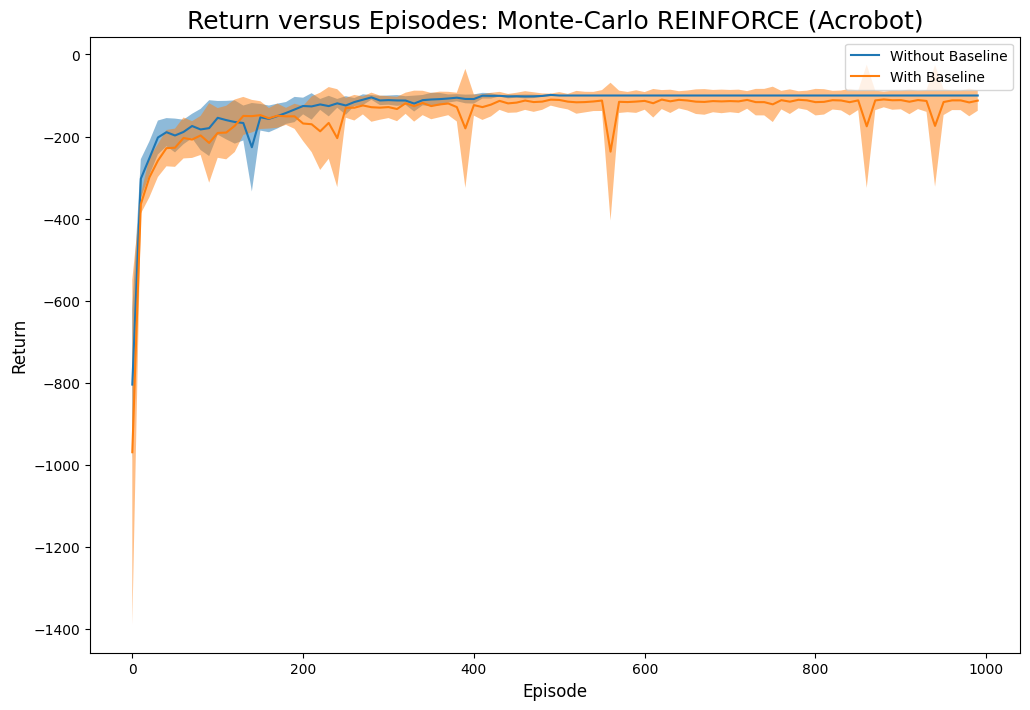

In [29]:
return_vs_episodes([no_baseline_rewards, with_baseline_rewards], ['Without Baseline', 'With Baseline'], 'Return versus Episodes: Monte-Carlo REINFORCE (Acrobot)')